# Part 2: Automated ML pipeline

MLRun Project is a container for all your work on a particular activity: all of the associated code, functions, 
jobs/workflows and artifacts. Projects can be mapped to `git` repositories, which enable versioning, collaboration, and CI/CD.
Users can create project definitions using the SDK or a yaml file and store those in MLRun DB, file, or archive.
Once the project is loaded you can run jobs/workflows that refer to any project element by name, allowing separation between configuration and code. 

Projects contain `workflows` that execute the registered functions in a sequence/graph (DAG), can reference project 
parameters, secrets and artifacts by name. This notebook demonstrates how to build an automated workflow with 
**feature selection**, **training**, **testing**, and **deployment**. 

In [1]:
project_name = 'fraud-demo'

In [2]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2023-06-21 11:09:15,735 [info] loaded project fraud-demo from MLRun DB


## Step 1: Updating project and function definitions

You need to save the definitions for the function you use in the projects. This enables automatically converting code 
to functions or import external functions whenever you load new versions of your code or when you run automated CI/CD 
workflows. In addition, you may want to set other project attributes such as global parameters, secrets, and data.

Your code can be stored in Python files, notebooks, external repositories, packaged containers, etc. You use the 
`project.set_function()` method to register your code in the project. The definitions are saved to the project object, as 
well as in a YAML file in the root of our project.
Functions can also be imported from MLRun marketplace (using the `hub://` schema).

This tutorial uses these functions:
- `feature_selection` &mdash; the first function, which determines the top features to be used for training.
- `train` &mdash; the model-training function
- `evaluate` &mdash; the model-testing function
- `mlrun-model` &mdash; the model-serving function

`set_function` uses the `code_to_function` and `import_function` methods under the hood (used in the previous notebooks), but in addition it saves the function configurations in the project spec for use in automated workflows and CI/CD. 

Add the function definitions to the project along with parameters and data artifacts and save the project.

<a id="gs-tutorial-4-view-project-functions"></a>

In [3]:
project.set_function('hub://feature_selection', 'feature-selection')
project.set_function('hub://auto_trainer','train')
project.set_function('hub://v2_model_server', 'serving')

In [4]:
# set project level parameters and save
project.spec.params = {'label_column': 'label'}
project.save()

<br>When you save the project it stores the project definitions in the `project.yaml`. This allows you to load the project 
from the source control (GIT) and run it with a single command or API call.

The project YAML for this project can be printed using:

In [5]:
print(project.to_yaml())

kind: project
metadata:
  name: fraud-demo-admin
  created: '2023-06-21T10:54:50.826000'
spec:
  params:
    label_column: label
  functions:
  - url: hub://feature_selection
    name: feature-selection
  - url: hub://auto_trainer
    name: train
  - url: hub://v2_model_server
    name: serving
  workflows:
  - path: src/new_train_workflow.py
    name: main
  artifacts: []
  conda: ''
  source: git://github.com/mlrun/demo-fraud.git#refs/heads/main
  origin_url: git://github.com/mlrun/demo-fraud.git#refs/heads/main
  desired_state: online
  owner: admin
  build:
    commands: []
    requirements: []
status:
  state: online



### Saving and loading projects from GIT

After you saved your project and its elements (functions, workflows, artifacts, etc.) you can commit all your changes to a 
GIT repository. This can be done using standard GIT tools or using MLRun `project` methods such as `pull`, `push`, 
`remote`, which calls the Git API for you.

Projects can then be loaded from Git using MLRun `load_project` method, for example: 

    project = mlrun.load_project("./myproj", "git://github.com/mlrun/project-demo.git", name=project_name)
    
or using MLRun CLI:

    mlrun project -n myproj -u "git://github.com/mlrun/project-demo.git" ./myproj
    
Read [CI/CD integration](../../projects/ci-integration.html) for more details.

## Step 2 - Create a feature vector  
In this section you create a feature vector.  
The Feature vector has a `name` so you can reference to it later via the URI or your serving function, and it has a list of 
`features` from the available feature sets.  You can add a feature from a feature set by adding `<FeatureSet>.<Feature>` to 
the list, or add `<FeatureSet>.*` to add all the feature set's available features.  

By default, the first FeatureSet in the feature list acts as the spine, meaning that all the other features are joined to it.  
For example, in this instance you use the early sense sensor data as the spine, so for each early sense event you create produces a row in the resulted feature vector.

In [6]:
# Define the list of features to use
features = ['events.*',
            'transactions.amount_max_2h', 
            'transactions.amount_sum_2h', 
            'transactions.amount_count_2h',
            'transactions.amount_avg_2h', 
            'transactions.amount_max_12h', 
            'transactions.amount_sum_12h',
            'transactions.amount_count_12h', 
            'transactions.amount_avg_12h', 
            'transactions.amount_max_24h',
            'transactions.amount_sum_24h', 
            'transactions.amount_count_24h', 
            'transactions.amount_avg_24h',
            'transactions.es_transportation_sum_14d', 
            'transactions.es_health_sum_14d',
            'transactions.es_otherservices_sum_14d', 
            'transactions.es_food_sum_14d',
            'transactions.es_hotelservices_sum_14d', 
            'transactions.es_barsandrestaurants_sum_14d',
            'transactions.es_tech_sum_14d', 
            'transactions.es_sportsandtoys_sum_14d',
            'transactions.es_wellnessandbeauty_sum_14d', 
            'transactions.es_hyper_sum_14d',
            'transactions.es_fashion_sum_14d', 
            'transactions.es_home_sum_14d', 
            'transactions.es_travel_sum_14d', 
            'transactions.es_leisure_sum_14d',
            'transactions.gender_F',
            'transactions.gender_M',
            'transactions.step', 
            'transactions.amount', 
            'transactions.timestamp_hour',
            'transactions.timestamp_day_of_week']

In [7]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore

# Define the feature vector name for future reference
fv_name = 'transactions-fraud'

# Define the feature vector using the feature store (fstore)
transactions_fv = fstore.FeatureVector(fv_name, 
                          features, 
                          label_feature="labels.label",
                          description='Predicting a fraudulent transaction')

# Save the feature vector in the feature store
transactions_fv.save()

## Step 3 - Preview the feature vector data

Obtain the values of the features in the feature vector, to ensure the data appears as expected.

In [8]:
# Import the Parquet Target so you can directly save your dataset as a file
from mlrun.datastore.targets import ParquetTarget

# Get offline feature vector as dataframe and save the dataset to parquet
train_dataset = fstore.get_offline_features(fv_name, target=ParquetTarget())

> 2023-06-21 11:09:19,480 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/fraud-demo-admin/FeatureStore/transactions-fraud/parquet/vectors/transactions-fraud-latest.parquet', 'status': 'ready', 'updated': '2023-06-21T11:09:19.480454+00:00', 'size': 151303, 'partitioned': True}


In [9]:
# Preview your dataset
train_dataset.to_dataframe().head()

,event_password_change,event_details_change,event_login,amount_max_2h,amount_sum_2h,amount_count_2h,amount_avg_2h,amount_max_12h,amount_sum_12h,amount_count_12h,...,es_home_sum_14d,es_travel_sum_14d,es_leisure_sum_14d,gender_F,gender_M,step,amount,timestamp_hour,timestamp_day_of_week,label
0,0,0,1,1.83,1.83,1.0,1.830000,1.83,1.83,1.0,...,0.0,0.0,0.0,0.0,1.0,72.0,1.83,11.0,0.0,0.0
1,0,0,1,18.72,40.22,3.0,13.406667,18.72,40.22,3.0,...,0.0,0.0,0.0,0.0,1.0,66.0,18.72,11.0,0.0,0.0
2,1,0,0,25.92,64.86,3.0,21.620000,25.92,64.86,3.0,...,0.0,0.0,0.0,0.0,1.0,27.0,25.92,11.0,0.0,0.0
3,1,0,0,24.75,30.17,2.0,15.085000,24.75,30.17,2.0,...,0.0,0.0,0.0,0.0,1.0,141.0,24.75,11.0,0.0,0.0
4,1,0,0,64.18,65.17,2.0,32.585000,64.18,65.17,2.0,...,0.0,0.0,0.0,1.0,0.0,124.0,64.18,11.0,0.0,0.0


## Step 4: Registering the workflow

You're now ready to create a full ML pipeline.
This is done by using [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/overview/pipelines-overview/) &mdash;
an open-source framework for building and deploying portable, scalable machine-learning workflows based on Docker containers.
MLRun leverages this framework to take your existing code and deploy it as steps in the pipeline.

Use the `set_workflow` MLRun project method to register your workflow with MLRun.
The following code sets the `name` parameter to the selected workflow name ("main") and the `code` parameter to the name of 
the workflow file that is found in your project directory (**workflow.py**).

In [10]:
# Register the workflow file as "main"
project.set_workflow('main', 'src/new_train_workflow.py')

## Step 5: Running a pipeline

First run the following code to save your project:

In [11]:
project.save()

Use the `run` MLRun project method to execute your workflow pipeline with Kubeflow Pipelines.

You can pass **`arguments`** or set the **`artifact_path`** to specify a unique path for storing the workflow artifacts.

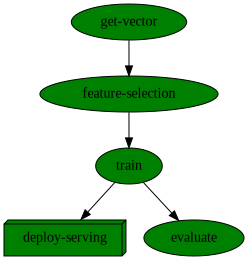

In [12]:
run_id = project.run(
    'main',
    arguments={'vector_name':"transactions-fraud",
                'label_column':"labels.label",
                'model_name':"fraud_detection"}, 
    dirty=True, watch=True)

## Step 6: Test the model endpoint


Now that your model is deployed using the pipeline, you can invoke it as usual:

In [13]:
# Define your serving function
serving_fn = project.get_function('serving')

# Choose an id for your test
sample_id = 'C1000148617'
model_inference_path = '/v2/models/fraud/infer'

# Send our sample ID for predcition
serving_fn.invoke(path=model_inference_path,
                  body={'inputs': [[sample_id]]})

> 2023-06-21 11:15:51,762 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-admin-serving.default-tenant.svc.cluster.local:8080/v2/models/fraud/infer'}


{'id': '256d9289-1b1e-427b-9031-1432396f6f2f',
 'model_name': 'fraud',
 'outputs': [0]}

## Done!

You've completed Part 2 of the model training with the feature store.
Proceed to [Part 3](03-deploy-serving-model.html) to learn how to deploy and monitor the model.